# Example: DoT-score to analyse haematopoeitic progenitrs

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import dotscore
import matplotlib.pyplot as plt

## Preparing data

### Loading gene expression changes

As an example we will use RNA-Seq data from Kucinski et al. 2020.
The study uses Hoxb8-FL cell line, which models an intermediate blood progenitor state with lymphoid and myeloid potential.
Here we are loading transcriptional changes following:
- switching off Hoxb8 overexpression for 16h (noB). Hoxb8 maintains the self-renewal and multipotency of the cells and its loss leads to dendritic cells after 4-5 days.
- Ikzf1 knockout introduced by CRISPR/Cas9 (ik1)

Loading DataFrames with genes differentially expressed in each case.


In [2]:
noB = pd.read_csv('../dotscore/data/noB_weights.csv', index_col = 0)
ik1 = pd.read_csv('../dotscore/data/ik1_weights.csv', index_col = 0)

*Optional but recommended:* if we want to compute z-scores we need:
- the background list of genes used for simulating DoT-scores, here we will use all genes expressed in Hoxb8-FL cells (allgenes).
- a set of weights, following a similar distribution the observed changes, which can be used for simulating data. We will use the set of all observed changes in gene expression from the entire study (allfolds)

In [3]:
counts = pd.read_csv('../dotscore/data/Hoxb8_expressedgenes.csv', index_col = 0)
allgenes = counts.index.values

In [4]:
allfolds = pd.read_csv('../dotscore/data/weightset.csv', index_col = 0)
allfolds = allfolds.log2FoldChange.values

### Loading scRNA-Seq data

DoT-score requires a scRNA-Seq landscape as a reference. Here we will utilise a small sample of cells published in the Dahlin et al. 2018 paper (https://ashpublications.org/blood/article-lookup/doi/10.1182/blood-2017-12-821413). It is a mixture of cells isolated from the Lin-/cKit+ and Lin-/cKit+/Sca1+ populations, thus contain blood stem cells as well as progenitors biased towards specific lineages (e.g. myeloid or megakaryocytes).

In [5]:
x = sc.read('../dotscore/data/tiny_example2.h5ad')
x.var.index = x.var.geneid
x.obsm['X_umap'] = x.obsm['X_umap_noG']

/Users/idk25/miniconda3/lib/python3.7/site-packages/anndata/compat/__init__.py:182: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,
/Users/idk25/miniconda3/lib/python3.7/site-packages/anndata/compat/__init__.py:182: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  FutureWarning,


Displaying the cell clusters on the UMAP projection, which does a pretty good job at laying out cell differentiation trajectories:
- cluster 12 - stem cells
- cluster 7 - megakaryocyte progenitors
- clusters 8 and 15 - myeloid progenitors
- cluster 19 - lymphoid progenitors
- clusters 10, 6, 0 - erythroid progenitors

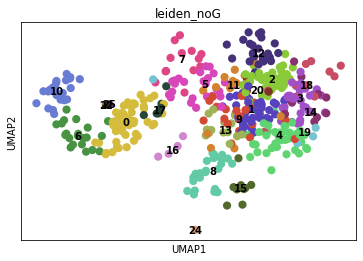

In [6]:
sc.pl.umap(x, color = 'leiden_noG', legend_loc = 'on data')

## DoT-score calculation

#### Scaling gene expression

First we need to define the cell state of origin, i.e. the vector of gene expression which will be the basis for scaling for all the other cells. In this case we will use the mean expression values of cells belonging to the cluster 4, which are a good match for the Hoxb8-FL cells. 

In [7]:
x[x.obs.leiden_noG == '4',:].X.mean(axis = 0)
means4 = x[x.obs.leiden_noG == '4',:].X.mean(axis = 0)
dotscore.custom_scale(x, mean = means4)

#### DoT-score

We compute the DoT-score using the 'noB' expression changes (Hoxb8-FL cells after switching off Hoxb8 expression) and adding the values to the AnnData object. We provide the DataFrame with gene expression changes (noB) and specify which column correspond to the gene IDs (here: 'target') and which contain the weight (here: 'log2FoldChange'). 'Target' and 'log2FoldChange' are also default arguments, so we can skip them later.

In [8]:
x.obs['DoT'] = dotscore.get_DoTscore(x, noB, zscore = False, id_col = 'target', weight_col = 'log2FoldChange')

We can visualise the score using the UMAP projection and color-code cells according to their DoT scores. We use the cmap_RdBu function to generate a Red-Blue colorscale

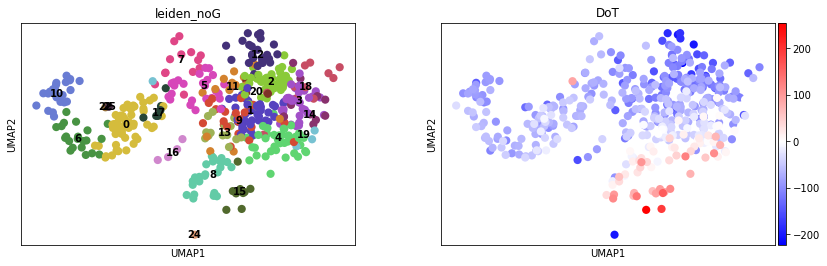

In [9]:
cmap = dotscore.cmap_RdBu(x.obs['DoT'])
sc.pl.umap(x, color = ['leiden_noG', 'DoT'], legend_loc = 'on data', cmap = cmap)

The DoT score shows strongly positive values in the lower parts of the landscape which correspond to the myeloid trajectory. The highest score is in the cluster 15, which cotains progenitors beginning to express monocytic and dendritic cell markers (e.g. Irf8).
This is consistent with the fact that Hoxb8-FL cells differentiate into dendritic cells after switching off Hoxb8 expression. DoT score highlights this state transition, even when using data from very early stages (here 16 hours).


Similarly, we can calculate the DoT-score for the effect of Ikzf1 loss in Hoxb8-FL cells

In [10]:
x.obs['DoT'] = dotscore.get_DoTscore(x, ik1, zscore = False)

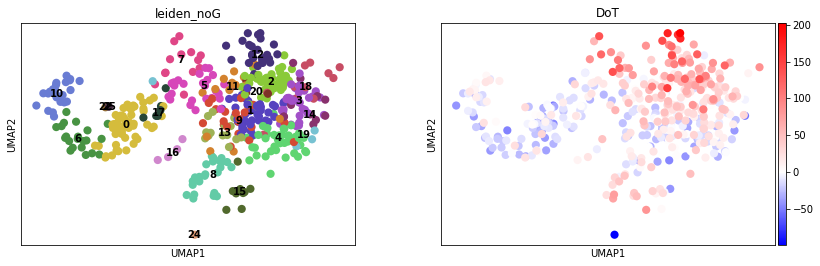

In [11]:
cmap = dotscore.cmap_RdBu(x.obs['DoT'])
sc.pl.umap(x, color = ['leiden_noG', 'DoT'], legend_loc = 'on data', cmap = cmap)

In this case we see a strongly positive DoT score in clusters 12 and 7, which correspond to blood stem cells and megakaryocyte progenitors respectively, indicating cell state shift in that direction. We will look closer at the genes involved in this in section: **"Which genes contribute to the DoT score?"**

#### Recommended: DoT-score with z-scores

To get an idea how significant the observed score values are, we can calculate z-scores using simulated data. To do this, we need to provide a set of genes (allgenes) and weights (allfolds) to be used for simulations. We will again look at the consequences of losing Hoxb8 expression (noB):

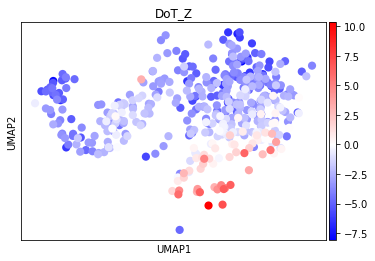

In [12]:
x.obs['DoT_Z'] = dotscore.get_DoTscore(x, noB, allgenes, allfolds, zscore = True)
cmap = dotscore.cmap_RdBu(x.obs['DoT_Z'])
sc.pl.umap(x, color = 'DoT_Z', cmap = cmap)

High z-score values indicates that the observed pattern is very unlikely to be random.

#### Optional: Filtering noisy cells

As scRNA-Seq data is noisy, in larger datasets it is sometimes useful to filter out the outlier cells. In this particular it's not really necessary but we provide a convenient function for quantile filtering. The function changes values above a certain quantile to the value equal to that quantile.

Filtering: 5 cells above threshold (6.31970229600304)
Filtering: 5 cells below threshold (-6.693513370268452)


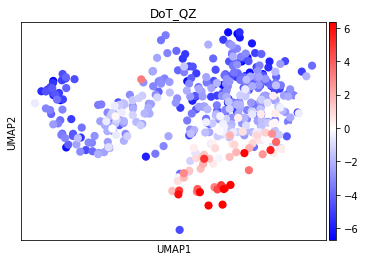

In [13]:
x.obs['DoT_QZ'] = dotscore.qfilt(x.obs['DoT_Z'])
cmap = dotscore.cmap_RdBu(x.obs['DoT_QZ'])
sc.pl.umap(x, color = 'DoT_QZ', cmap = cmap)

### Which genes contribute to the DoT score?

We recompute here the DoT score for effects of losing Ikzf1 in Hoxb8-FL cells, this time with z-score to confirm that the effect is not random.

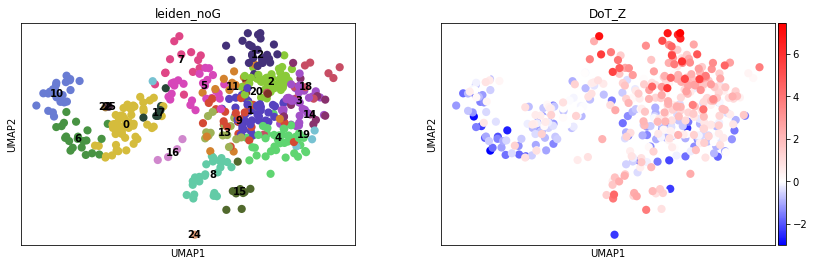

In [14]:
x.obs['DoT_Z'] = dotscore.get_DoTscore(x, ik1, allgenes, allfolds, zscore = True)
cmap = dotscore.cmap_RdBu(x.obs['DoT_Z'])
sc.pl.umap(x, color = ['leiden_noG', 'DoT_Z'], cmap = cmap, legend_loc = 'on data')

It's quite clear that there is a strong shift towards clusters 7 and 12, but which genes are involved? We can investigate this by computing an intermediate step during DoT score calculation -  scores for each gene, which after summing up would give us the DoT-score. As the data is quite large and noisy, we average the 'gene scores' for each cluster.

To get the gene score we use the function get_genescore_pergroup, with:
- the AnnData object
- changes in expression
- name of the column in the .obs slot of the AnnData object which corresponds to gene groups
- name of the cell group by which scores should be sorted
- additional annotation for gene symbols - name of the column in the .var slot

In [15]:
genescore = dotscore.get_genescore_pergroup(x, ik1, group = 'leiden_noG', sortby = '12', gene_symbols = 'symbol')

We look at specific genes with the highest contribution scores. The list indeed contains several genes highly expressed in stem cells (Scarf1, Eng, Lpl), including a classic stem cell marker - Procr, thus supporting our prediction that the cells aquire some of the stem cell gene expression programme.

In [16]:
genescore[['12', 'symbol']].tail(10)

,12,symbol
geneid,,
ENSMUSG00000022440,1.835111,C1qtnf6
ENSMUSG00000038576,2.011571,Susd4
ENSMUSG00000015568,2.024287,Lpl
ENSMUSG00000027611,2.245009,Procr
ENSMUSG00000026814,2.289988,Eng
ENSMUSG00000043505,2.350197,Gimap5
ENSMUSG00000046768,2.773567,Rhoj
ENSMUSG00000028885,2.995535,Smpdl3b
ENSMUSG00000038188,3.727359,Scarf1


We can also have a closer look at the distribution of genescores. To do this we plot the cummulative sum of gene scores against the sorted genes. Although there is a small number of genes with negative contributions, the positive contributions quickly overtake and the average score becomes strongly positive in the end

Text(0.5, 0, 'Sorted genes')

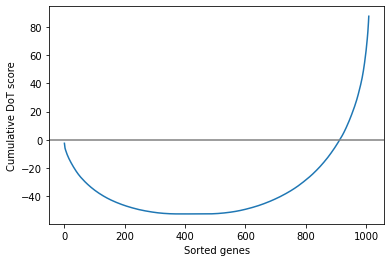

In [17]:
genescore = genescore.loc[genescore.sum(axis = 1) != 0, :] #Excluding genes with0 contributions
plt.plot(range(genescore.shape[0]), np.cumsum(genescore['12']))
plt.axhline(y=0, color = 'grey')
plt.ylabel("Cumulative DoT score")
plt.xlabel("Sorted genes")